C:\Users\lopis\AppData\Local\Temp\ipykernel_24900\653028278.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("C:/MLCourse/My_Exercises/A

Threshold (95th percentile): 0.012078
Anomalies at windows: [ 61 140 141 142 143 144 145 146 192 193]


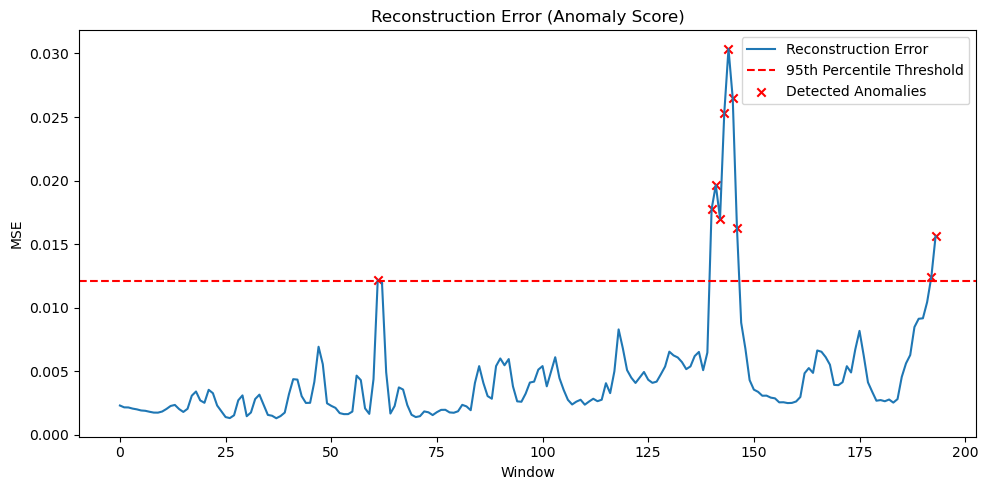

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from model import LSTMAutoencoder
from preprocessing import load_data, normalize_data, segment_windows

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def main():
    # Load and preprocess data
    df = load_data()
    if 'label' in df.columns:
        df = df.drop(columns=['label'])
    data_norm = normalize_data(df)
    windows = segment_windows(data_norm, window_size=50, step_size=25)

    X = torch.tensor(windows, dtype=torch.float32).to(DEVICE)

    # Model params
    seq_len = X.shape[1]
    n_features = X.shape[2]
    embedding_dim = 64

    # Load model
    model = LSTMAutoencoder(seq_len, n_features, embedding_dim).to(DEVICE)
    model.load_state_dict(torch.load("C:/MLCourse/My_Exercises/Autonomous System/Data/lstm_autoencoder.pth"))
    model.eval()

    # Reconstruction error (MSE) for each window
    with torch.no_grad():
        reconstructed = model(X)
        mse = torch.mean((X - reconstructed) ** 2, dim=(1, 2)).cpu().numpy()

    # Determine threshold using percentile
    threshold = np.percentile(mse, 95)
    anomalies = mse > threshold
    anomaly_indices = np.where(anomalies)[0]

    print(f"Threshold (95th percentile): {threshold:.6f}")
    print(f"Anomalies at windows: {anomaly_indices}")

    # Plot reconstruction error and threshold
    plt.figure(figsize=(10, 5))
    plt.plot(mse, label='Reconstruction Error')
    plt.axhline(threshold, color='red', linestyle='--', label=f'95th Percentile Threshold')
    plt.scatter(anomaly_indices, mse[anomaly_indices], color='red', marker='x', label='Detected Anomalies')
    plt.xlabel('Window')
    plt.ylabel('MSE')
    plt.title('Reconstruction Error (Anomaly Score)')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [3]:
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from model import LSTMAutoencoder
from preprocessing import normalize_data, segment_windows

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load labeled data
df = pd.read_csv(r"C:\MLCourse\My_Exercises\Autonomous System\Data\filtered_sensor_data_with_labels.csv")

# Extract labels & drop from features
labels = df['label'].values
df_features = df.drop(columns=['label'])

# Normalize & segment
data_norm = normalize_data(df_features)
windows = segment_windows(data_norm, window_size=50, step_size=25)

# Assign a label per window (if ANY anomaly is present → window is anomalous)
window_labels = []
for start in range(0, len(labels) - 50 + 1, 25):
    window = labels[start:start+50]
    window_labels.append(int(np.max(window)))  # 1 if any anomaly, else 0
window_labels = np.array(window_labels)

# Prepare data
X = torch.tensor(windows, dtype=torch.float32).to(DEVICE)

# Load trained model
seq_len, n_features = X.shape[1], X.shape[2]
embedding_dim = 64
model = LSTMAutoencoder(seq_len, n_features, embedding_dim).to(DEVICE)
model.load_state_dict(torch.load("C:/MLCourse/My_Exercises/Autonomous System/Data/lstm_autoencoder.pth"))
model.eval()

# Compute reconstruction errors (MSE)
with torch.no_grad():
    reconstructed = model(X)
    mse = torch.mean((X - reconstructed) ** 2, dim=(1,2)).cpu().numpy()

# --- Dynamic threshold from ROC ---
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(window_labels, mse)
youden_j = tpr - fpr
best_threshold = thresholds[np.argmax(youden_j)]
print(f"Best threshold from ROC: {best_threshold:.5f}")

# Predict using best threshold
y_pred = (mse > best_threshold).astype(int)


# Metrics
cm = confusion_matrix(window_labels, y_pred)
precision = precision_score(window_labels, y_pred, zero_division=0)
recall = recall_score(window_labels, y_pred, zero_division=0)
f1 = f1_score(window_labels, y_pred, zero_division=0)
roc_auc = roc_auc_score(window_labels, mse)
fpr, tpr, _ = roc_curve(window_labels, mse)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming cm, precision, recall, f1, roc_auc are already calculated
print("\n📊 Evaluation Results\n")
print(f"Confusion Matrix [TN FP; FN TP]:\n{cm}")
print(f"\n🔎 Precision: {precision:.3f}")
print(f"🎯 Recall:    {recall:.3f}")
print(f"📐 F1-score:  {f1:.3f}")
print(f"📈 ROC-AUC:   {roc_auc:.3f}")

Best threshold from ROC: 0.02893

📊 Evaluation Results

Confusion Matrix [TN FP; FN TP]:
[[  7   8]
 [ 42 137]]

🔎 Precision: 0.945
🎯 Recall:    0.765
📐 F1-score:  0.846
📈 ROC-AUC:   0.561


C:\Users\lopis\AppData\Local\Temp\ipykernel_24900\2874510468.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("C:/MLCourse/My_Exercises/

In [ ]:
# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--', c='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Anomaly Detection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()